# Analysis of Data Related to European Football Leagues

# Introduction

# Goals

1. Determine if any set of features would more likely result in a human tester giving the wine a high score of 7 or 8. 
2. Determine if any set of features would determine the alcohol content of the wine. 

# Technical Requirements

1. Perform exploratory data analysis.
2. Do hypothesis testing.
3. Apply machine learning models.
4. Provide clear explanations. 
5. Provide conclusions and suggestions about how the analysis can be improved.

# Standards

Below is a summary of the standards I followed to create this report. 

>* **Standard 1:** Since one of my goals was to determine what makes wine, "good," I concentrated on wines that received a high quality score of 7 or 8.
>* **Standard 2:** For correlation between features in the dataset, my threshold was 0.8 or higher to indicate a correlation.

# Biases

Below are the biases I identified while creating this report.

>* **Bias 1:** The number of wines in each quality category varies. For example, there are only 18 wines of quality 8 compared with 681 wines of quality 5. It is hard to trust our conclusions fully since we don't have a balance in the amount of data in each quality category. This creates a significant bias. 
>* **Bias 2:** I have no expertise in wine production or testing. There may be parts of the data that I have overlooked that may have been most important and I may have given importance to parts of the data that may have had little significance. 

# Libraries

In [541]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import warnings
import xml.etree.ElementTree as ET
import eli5 as eli

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from xml.etree.ElementTree import fromstring, ElementTree
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance

# Display Parameters

## Display Features

In [82]:
%matplotlib inline
pd.options.display.max_rows = 300000
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 500
warnings.filterwarnings("ignore")

## Colors

In [83]:
color_1 = "bisque"
color_2 = "crimson"
color_3 = "orangered"
color_4 = "lightcoral"
color_5 = "royalblue"
color_6 = "pink"
color_7 = "indianred"
color_8 = "slategrey"
color_9 = "salmon"
color_10 = "beige"
color_11 = "coral"
color_13 = "grey"
color_14 = "tan"
color_15 = "wheat"
color_16 = "tomato"

## Figure Parameters

In [84]:
size = 20

params = {
    "font.family": "Times New Roman",
    "font.size": size,
    "axes.labelsize": size,
    "xtick.labelsize": size * 0.75,
    "ytick.labelsize": size * 0.75,
    "figure.titlesize": size * 1.5,
    "axes.titlesize": size * 1.5,
    "axes.titlepad": size,
    "axes.labelpad": size - 10,
    "lines.linewidth": 2,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.spines.bottom": False,
    "legend.fontsize": size,
}

# Load Raw Data

In [79]:
football = sqlite3.connect(
    "C:\\Users\\Space\\Documents\\py\\Projects\\TuringCollege\\Football\\database.sqlite"
)

In [80]:
football_db = {}

result = football.execute("SELECT name FROM sqlite_master WHERE type='table';")

for table in result:
    query = "SELECT * from " + str(table[0]) + ";"
    football_db[table[0]] = pd.read_sql_query(query, football)

football_db.keys()

dict_keys(['sqlite_sequence', 'Player_Attributes', 'Player', 'Match', 'League', 'Country', 'Team', 'Team_Attributes'])

# Country

In [81]:
country = football_db["Country"].copy()

In [82]:
country.rename(columns={"id": "CountryID", "name": "CountryName"}, inplace=True)

In [84]:
country.shape

(11, 2)

# League

In [85]:
league = football_db["League"].copy()

In [86]:
del league["id"]
league.rename(columns={"country_id": "CountryID", "name": "LeagueName"}, inplace=True)

In [87]:
league.shape

(11, 2)

In [ ]:
league

In [255]:
league = league.rename(columns = {'CountryID':'LeagueID'})

In [256]:
league.head()

,LeagueID,LeagueName
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A


# Team

In [361]:
team = football_db["Team"].copy()

In [362]:
team.drop(columns=["id", "team_fifa_api_id"], inplace=True)

In [363]:
team.rename(
    columns={
        "team_api_id": "TeamID",
        "team_long_name": "TeamLongName",
        "team_short_name": "TeamShortName",
    },
    inplace=True,
)

In [364]:
team.head()

,TeamID,TeamLongName,TeamShortName
0,9987,KRC Genk,GEN
1,9993,Beerschot AC,BAC
2,10000,SV Zulte-Waregem,ZUL
3,9994,Sporting Lokeren,LOK
4,9984,KSV Cercle Brugge,CEB


In [365]:
team.shape

(299, 3)

In [366]:
team[team.duplicated()].sum()

TeamID           0.0
TeamLongName     0.0
TeamShortName    0.0
dtype: float64

In [367]:
team.isnull().sum()

TeamID           0
TeamLongName     0
TeamShortName    0
dtype: int64

# Match

In [403]:
match = football_db["Match"].copy()

In [404]:
match.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,home_player_X5,home_player_X6,home_player_X7,home_player_X8,home_player_X9,home_player_X10,home_player_X11,away_player_X1,away_player_X2,away_player_X3,away_player_X4,away_player_X5,away_player_X6,away_player_X7,away_player_X8,away_player_X9,away_player_X10,away_player_X11,home_player_Y1,home_player_Y2,home_player_Y3,home_player_Y4,home_player_Y5,home_player_Y6,home_player_Y7,home_player_Y8,home_player_Y9,home_player_Y10,home_player_Y11,away_player_Y1,away_player_Y2,away_player_Y3,away_player_Y4,away_player_Y5,away_player_Y6,away_player_Y7,away_player_Y8,away_player_Y9,away_player_Y10,away_player_Y11,home_player_1,home_player_2,home_player_3,home_player_4,home_player_5,home_player_6,home_player_7,home_player_8,home_player_9,home_player_10,home_player_11,away_player_1,away_player_2,away_player_3,away_player_4,away_player_5,away_player_6,away_player_7,away_player_8,away_player_9,away_player_10,away_player_11,goal,shoton,shotoff,foulcommit,card,cross,corner,possession,B365H,B365D,B365A,BWH,BWD,BWA,IWH,IWD,IWA,LBH,LBD,LBA,PSH,PSD,PSA,WHH,WHD,WHA,SJH,SJD,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.73,3.40,5.00,1.75,3.35,4.20,1.85,3.2,3.5,1.80,3.3,3.75,NaN,NaN,NaN,1.70,3.30,4.33,1.90,3.3,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.95,3.20,3.60,1.80,3.30,3.95,1.90,3.2,3.5,1.90,3.2,3.50,NaN,NaN,NaN,1.83,3.30,3.60,1.95,3.3,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,2.38,3.30,2.75,2.40,3.30,2.55,2.60,3.1,2.3,2.50,3.2,2.50,NaN,NaN,NaN,2.50,3.25,2.40,2.63,3.3,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,1.44,3.75,7.50,1.40,4.00,6.80,1.40,3.9,6.0,1.44,3.6,6.50,NaN,NaN,NaN,1.44,3.75,6.00,1.44,4.0,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None,None,None,None,None,None,None,5.00,3.50,1.65,5.00,3.50,1.60,4.00,3.3,1.7,4.00,3.4,1.72,NaN,NaN,NaN,4.20,3.40,1.70,4.50,3.5,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [405]:
def extract_xml(row, col_name, xml_key, away_home):
    count = 0

    element = row[col_name]
    team_id = row[away_home + "_team_api_id"]

    if type(element) == int:
        return element

    elif element != None:
        tree = ElementTree(fromstring(element))
        root = tree.getroot()

        for child in root.iter(xml_key):
            if str(team_id) == child.text:
                count += 1
        return count
    else:
        return np.nan

In [406]:
def extract_possession_xml(row, col_name, xml_key):
    count = 0
    sum_pos = 0

    element = row[col_name]

    if type(element) == int:
        return element

    elif element != None:
        tree = ElementTree(fromstring(element))
        root = tree.getroot()
        for child in root.iter(xml_key):
            count += 1
            sum_pos += int(child.text)

        if count == 0:
            return np.nan
        else:
            return sum_pos / count
    else:
        return np.nan

In [407]:
match = football_db["Match"].copy()

In [408]:
match["HomeShoton"] = np.nan
match["AwayShoton"] = np.nan

In [409]:
match["HomeShoton"] = match.apply(
    lambda x: extract_xml(x, "shoton", "team", "home"), axis=1
)
match["AwayShoton"] = match.apply(
    lambda x: extract_xml(x, "shoton", "team", "away"), axis=1
)

In [410]:
match["HomeShotoff"] = np.nan
match["AwayShotoff"] = np.nan

In [411]:
match["HomeShotoff"] = match.apply(
    lambda x: extract_xml(x, "shotoff", "team", "home"), axis=1
)
match["AwayShotoff"] = match.apply(
    lambda x: extract_xml(x, "shotoff", "team", "away"), axis=1
)

In [412]:
match["HomeFoulCommit"] = np.nan
match["AwayFoulCommit"] = np.nan

In [413]:
match["HomeFoulCommit"] = match.apply(
    lambda x: extract_xml(x, "foulcommit", "team", "home"), axis=1
)
match["AwayFoulCommit"] = match.apply(
    lambda x: extract_xml(x, "foulcommit", "team", "away"), axis=1
)

In [414]:
match["HomeCard"] = np.nan
match["AwayCard"] = np.nan

In [415]:
match["HomeCard"] = match.apply(
    lambda x: extract_xml(x, "card", "team", "home"), axis=1
)
match["AwayCard"] = match.apply(
    lambda x: extract_xml(x, "card", "team", "away"), axis=1
)

In [416]:
match["HomeCross"] = np.nan
match["AwayCross"] = np.nan

In [417]:
match["HomeCross"] = match.apply(
    lambda x: extract_xml(x, "cross", "team", "home"), axis=1
)
match["AwayCross"] = match.apply(
    lambda x: extract_xml(x, "cross", "team", "away"), axis=1
)

In [418]:
match["HomeCorner"] = np.nan
match["AwayCorner"] = np.nan

In [419]:
match["HomeCorner"] = match.apply(
    lambda x: extract_xml(x, "corner", "team", "home"), axis=1
)
match["AwayCorner"] = match.apply(
    lambda x: extract_xml(x, "corner", "team", "away"), axis=1
)

In [420]:
match["HomePossession"] = np.nan
match["AwayPossession"] = np.nan

In [421]:
match["HomePossession"] = match.apply(
    lambda x: extract_possession_xml(x, "possession", "homepos"), axis=1
)
match["AwayPossession"] = match.apply(
    lambda x: extract_possession_xml(x, "possession", "awaypos"), axis=1
)

In [422]:
match.drop(
    columns=["id", "stage", "country_id", "season"],
    inplace=True,
)

In [423]:
match.rename(
    columns={
        "league_id": "LeagueID",
        "match_api_id": "MatchID",
        "home_team_api_id": "HomeTeamID",
        "away_team_api_id": "AwayTeamID",
        "date": "Date",
        "home_team_goal": "HomeGoal",
        "away_team_goal": "AwayGoal",
        "home_player_1": "HomePlayer1",
        "home_player_2": "HomePlayer2",
        "home_player_3": "HomePlayer3",
        "home_player_4": "HomePlayer4",
        "home_player_5": "HomePlayer5",
        "home_player_6": "HomePlayer6",
        "home_player_7": "HomePlayer7",
        "home_player_8": "HomePlayer8",
        "home_player_9": "HomePlayer9",
        "home_player_10": "HomePlayer10",
        "home_player_11": "HomePlayer11",
        "away_player_1" :"AwayPlayer1",
        "away_player_2" :"AwayPlayer2",
        "away_player_3" :"AwayPlayer3",
        "away_player_4" :"AwayPlayer4",
        "away_player_5" :"AwayPlayer5",
        "away_player_6" :"AwayPlayer6",
        "away_player_7" :"AwayPlayer7",
        "away_player_8" :"AwayPlayer8",
        "away_player_9" :"AwayPlayer9",
        "away_player_10" :"AwayPlayer10",
        "away_player_11" :"AwayPlayer11",
        
    },
    inplace=True,
)

In [424]:
match.drop(match.iloc[:, 7:51], inplace = True, axis = 1)

In [425]:
match.drop(match.iloc[:, 29:67], inplace = True, axis = 1)

In [426]:
match["Date"] = pd.DatetimeIndex(match["Date"]).year

In [427]:
match.head()

,LeagueID,Date,MatchID,HomeTeamID,AwayTeamID,HomeGoal,AwayGoal,HomePlayer1,HomePlayer2,HomePlayer3,HomePlayer4,HomePlayer5,HomePlayer6,HomePlayer7,HomePlayer8,HomePlayer9,HomePlayer10,HomePlayer11,AwayPlayer1,AwayPlayer2,AwayPlayer3,AwayPlayer4,AwayPlayer5,AwayPlayer6,AwayPlayer7,AwayPlayer8,AwayPlayer9,AwayPlayer10,AwayPlayer11,HomeShoton,AwayShoton,HomeShotoff,AwayShotoff,HomeFoulCommit,AwayFoulCommit,HomeCard,AwayCard,HomeCross,AwayCross,HomeCorner,AwayCorner,HomePossession,AwayPossession
0,1,2008,492473,9987,9993,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2008,492474,10000,9994,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2008,492475,9984,8635,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,2008,492476,9991,9998,5,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,2008,492477,7947,9985,1,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Matches

In [463]:
matches = pd.merge(league, match, on="LeagueID", how="inner")

In [464]:
df_inner_Home = pd.merge(
    matches, teams, left_on=["HomeTeamID", "Date"], right_on=["TeamID", "Date"]
)

In [465]:
df_inner_Home.rename(
    columns={
        "TeamID": "HomeTeamID",
        "TeamLongName": "HomeTeamLongName",
        "TeamShortName": "HomeTeamShortName",
        "BuildUpPlaySpeed": "HomeBuildUpPlaySpeed",
        "BuildUpPlayPassing": "HomeBuildUpPlayPassing",
        "ChanceCreationPassing": "HomeChanceCreationPassing",
        "ChanceCreationCrossing": "HomeChanceCreationCrossing",
        "ChanceCreationShooting": "HomeChanceCreationShooting",
        "DefencePressure": "HomeDefencePressure",
        "DefenceAggression": "HomeDefenceAggression",
        "DefenceTeamWidth": "HomeDefenceTeamWidth",
    },
    inplace=True,
)

In [466]:
df_inner_Away = pd.merge(
    df_inner_Home, teams, left_on=["AwayTeamID", "Date"], right_on=["TeamID", "Date"]
)

In [467]:
df_inner_Away.rename(
    columns={
        "TeamID": "AwayTeamID",
        "TeamLongName": "AwayTeamLongName",
        "TeamShortName": "AwayTeamShortName",
        "BuildUpPlaySpeed": "AwayBuildUpPlaySpeed",
        "BuildUpPlayPassing": "AwayBuildUpPlayPassing",
        "ChanceCreationPassing": "AwayChanceCreationPassing",
        "ChanceCreationCrossing": "AwayChanceCreationCrossing",
        "ChanceCreationShooting": "AwayChanceCreationShooting",
        "DefencePressure": "AwayDefencePressure",
        "DefenceAggression": "AwayDefenceAggression",
        "DefenceTeamWidth": "AwayDefenceTeamWidth",
    },
    inplace=True,
)

In [468]:
matches = df_inner_Away

In [469]:
matches.head()

,LeagueID,LeagueName,Date,MatchID,HomeTeamID,AwayTeamID,HomeGoal,AwayGoal,HomePlayer1,HomePlayer2,HomePlayer3,HomePlayer4,HomePlayer5,HomePlayer6,HomePlayer7,HomePlayer8,HomePlayer9,HomePlayer10,HomePlayer11,AwayPlayer1,AwayPlayer2,AwayPlayer3,AwayPlayer4,AwayPlayer5,AwayPlayer6,AwayPlayer7,AwayPlayer8,AwayPlayer9,AwayPlayer10,AwayPlayer11,HomeShoton,AwayShoton,HomeShotoff,AwayShotoff,HomeFoulCommit,AwayFoulCommit,HomeCard,AwayCard,HomeCross,AwayCross,HomeCorner,AwayCorner,HomePossession,AwayPossession,HomeTeamID,HomeTeamLongName,HomeTeamShortName,HomeBuildUpPlaySpeed,HomeBuildUpPlayPassing,HomeChanceCreationPassing,HomeChanceCreationCrossing,HomeChanceCreationShooting,HomeDefencePressure,HomeDefenceAggression,HomeDefenceTeamWidth,AwayTeamID,AwayTeamLongName,AwayTeamShortName,AwayBuildUpPlaySpeed,AwayBuildUpPlayPassing,AwayChanceCreationPassing,AwayChanceCreationCrossing,AwayChanceCreationShooting,AwayDefencePressure,AwayDefenceAggression,AwayDefenceTeamWidth
0,1,Belgium Jupiler League,2010,665626,8635,8342,3,2,38391.0,33620.0,38388.0,38389.0,38253.0,69713.0,38393.0,148302.0,38378.0,38383.0,181276.0,37990.0,36832.0,21812.0,38336.0,39578.0,37979.0,11736.0,42594.0,38366.0,163670.0,75405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8635,RSC Anderlecht,AND,50,35,70,50,60,70,50,70,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
1,1,Belgium Jupiler League,2010,838635,8635,8342,2,2,38391.0,38389.0,38253.0,69713.0,94553.0,38378.0,69653.0,148302.0,12692.0,46552.0,181276.0,31226.0,36832.0,27508.0,39878.0,47411.0,39578.0,38366.0,52280.0,35412.0,163670.0,75405.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8635,RSC Anderlecht,AND,50,35,70,50,60,70,50,70,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
2,1,Belgium Jupiler League,2010,838544,9986,8342,0,5,104388.0,39977.0,93054.0,46666.0,93344.0,39145.0,26613.0,45469.0,40520.0,NaN,38732.0,31226.0,36832.0,39578.0,42594.0,47411.0,35412.0,51841.0,38336.0,52280.0,38366.0,163670.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9986,Sporting Charleroi,CHA,40,50,45,43,60,70,70,70,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
3,1,Belgium Jupiler League,2010,838714,8203,8342,0,1,39573.0,67950.0,39389.0,80184.0,67941.0,37112.0,38969.0,178291.0,67957.0,148286.0,148315.0,37990.0,36832.0,27508.0,39878.0,42594.0,39578.0,38336.0,38366.0,163670.0,52280.0,38440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8203,KV Mechelen,MEC,65,60,50,40,50,60,70,60,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
4,1,Belgium Jupiler League,2010,665737,9997,8342,1,1,37868.0,33595.0,37866.0,3329.0,149150.0,38354.0,178486.0,36836.0,45490.0,68120.0,5016.0,37990.0,36832.0,21812.0,11736.0,42594.0,39578.0,37979.0,38366.0,163670.0,27423.0,38440.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9997,Sint-Truidense VV,STT,50,50,50,50,50,50,50,50,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70


In [470]:
def overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe):

    df_merge = pd.merge(left_dataframe, right_dataframe, left_on=[date, player_id], right_on=[date, player], how='right')
    df_merge[player] = df_merge[rating_column]
    del df_merge[rating_column]
    del df_merge[player_id]

    return df_merge

In [471]:
overall_rating = players[["Date", "PlayerID", "OverallRating"]]

In [472]:
player = "HomePlayer1"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = matches


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [473]:
player = "HomePlayer2"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [474]:
player = "HomePlayer3"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [475]:
player = "HomePlayer4"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [476]:
player = "HomePlayer5"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [477]:
player = "HomePlayer6"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [478]:
player = "HomePlayer7"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [479]:
player = "HomePlayer8"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [480]:
player = "HomePlayer9"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [481]:
player = "HomePlayer10"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [482]:
player = "HomePlayer11"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [483]:
player = "AwayPlayer1"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [484]:
player = "AwayPlayer2"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [485]:
player = "AwayPlayer3"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [486]:
player = "AwayPlayer4"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [487]:
player = "AwayPlayer5"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [488]:
player = "AwayPlayer6"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [489]:
player = "AwayPlayer7"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [490]:
player = "AwayPlayer8"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [491]:
player = "AwayPlayer9"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [492]:
player = "AwayPlayer10"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [493]:
player = "AwayPlayer11"
date = "Date"
player_id = "PlayerID"
rating_column = "OverallRating"
left_dataframe = overall_rating
right_dataframe = df_merge


df_merge = overall_function(player, date, player_id, rating_column, left_dataframe, right_dataframe)

In [494]:
matches = df_merge

In [495]:
matches = matches.copy(deep=True)

matches['Result'] = matches['HomeGoal'] - matches['AwayGoal']
matches.loc[matches['Result'] < 0, 'Result'] = -1
matches.loc[matches['Result'] == 0, 'Result'] = 0
matches.loc[matches['Result'] > 0, 'Result'] = 1

result = matches.pop('Result')
matches.insert(8, 'Result', result)

In [516]:
def calculate_mean(df, column):
    df[column] = df[column].fillna(df[column].mean())
    
    return df

In [517]:
attribute_list = ['HomeShoton',
 'AwayShoton',
 'HomeShotoff',
 'AwayShotoff',
 'HomeFoulCommit',
 'AwayFoulCommit',
 'HomeCard',
 'AwayCard',
 'HomeCross',
 'AwayCross',
 'HomeCorner',
 'AwayCorner']

In [518]:
player_list = ['HomePlayer1',
 'HomePlayer2',
 'HomePlayer3',
 'HomePlayer4',
 'HomePlayer5',
 'HomePlayer6',
 'HomePlayer7',
 'HomePlayer8',
 'HomePlayer9',
 'HomePlayer10',
 'HomePlayer11',
 'AwayPlayer1',
 'AwayPlayer2',
 'AwayPlayer3',
 'AwayPlayer4',
 'AwayPlayer5',
 'AwayPlayer6',
 'AwayPlayer7',
 'AwayPlayer8',
 'AwayPlayer9',
 'AwayPlayer10',
 'AwayPlayer11',
               ]

In [519]:
column = player_list

matches = round(calculate_mean(matches, column), 1)

In [520]:
column = attribute_list

matches = round(calculate_mean(matches, column), 0)

In [521]:
matches.head()

,Date,LeagueID,LeagueName,MatchID,HomeTeamID,AwayTeamID,HomeGoal,AwayGoal,Result,HomePlayer1,HomePlayer2,HomePlayer3,HomePlayer4,HomePlayer5,HomePlayer6,HomePlayer7,HomePlayer8,HomePlayer9,HomePlayer10,HomePlayer11,AwayPlayer1,AwayPlayer2,AwayPlayer3,AwayPlayer4,AwayPlayer5,AwayPlayer6,AwayPlayer7,AwayPlayer8,AwayPlayer9,AwayPlayer10,AwayPlayer11,HomeShoton,AwayShoton,HomeShotoff,AwayShotoff,HomeFoulCommit,AwayFoulCommit,HomeCard,AwayCard,HomeCross,AwayCross,HomeCorner,AwayCorner,HomePossession,AwayPossession,HomeTeamID,HomeTeamLongName,HomeTeamShortName,HomeBuildUpPlaySpeed,HomeBuildUpPlayPassing,HomeChanceCreationPassing,HomeChanceCreationCrossing,HomeChanceCreationShooting,HomeDefencePressure,HomeDefenceAggression,HomeDefenceTeamWidth,AwayTeamID,AwayTeamLongName,AwayTeamShortName,AwayBuildUpPlaySpeed,AwayBuildUpPlayPassing,AwayChanceCreationPassing,AwayChanceCreationCrossing,AwayChanceCreationShooting,AwayDefencePressure,AwayDefenceAggression,AwayDefenceTeamWidth
0,2010,1,Belgium Jupiler League,665626,8635,8342,3,2,1,72.0,72.0,72.0,74.0,70.0,71.0,75.0,68.0,72.0,78.0,74.0,72.0,72.0,68.0,72.0,68.0,69.0,70.0,70.0,70.0,72.0,70.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,8635,RSC Anderlecht,AND,50,35,70,50,60,70,50,70,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
1,2010,1,Belgium Jupiler League,838635,8635,8342,2,2,0,72.0,74.0,70.0,71.0,60.0,72.0,69.0,68.0,68.0,72.0,74.0,73.0,72.0,68.0,67.0,72.0,68.0,70.0,72.0,72.0,72.0,70.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,8635,RSC Anderlecht,AND,50,35,70,50,60,70,50,70,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
2,2010,1,Belgium Jupiler League,838544,9986,8342,0,5,-1,55.0,63.0,62.0,64.0,64.0,63.0,66.0,72.0,61.0,72.0,63.0,73.0,72.0,68.0,70.0,72.0,72.0,64.0,72.0,72.0,70.0,72.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,9986,Sporting Charleroi,CHA,40,50,45,43,60,70,70,70,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
3,2010,1,Belgium Jupiler League,838714,8203,8342,0,1,-1,70.0,64.0,63.0,66.0,65.0,66.0,65.0,66.0,63.0,66.0,66.0,72.0,72.0,68.0,67.0,70.0,68.0,72.0,70.0,72.0,72.0,69.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,8203,KV Mechelen,MEC,65,60,50,40,50,60,70,60,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70
4,2010,1,Belgium Jupiler League,665737,9997,8342,1,1,0,68.0,70.0,65.0,64.0,65.0,66.0,63.0,72.0,64.0,62.0,73.0,72.0,72.0,68.0,70.0,70.0,68.0,69.0,70.0,72.0,71.0,69.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,9997,Sint-Truidense VV,STT,50,50,50,50,50,50,50,50,8342,Club Brugge KV,CLB,35,40,45,50,45,60,70,70


In [522]:
home_long = matches.pop('HomeTeamLongName')
matches.insert(5, 'HomeTeamLongName', home_long)

In [524]:
home_short = matches.pop('HomeTeamShortName')
matches.insert(6, 'HomeTeamShortName', home_short)

In [525]:
away_long = matches.pop('AwayTeamLongName')
matches.insert(8, 'AwayTeamLongName', away_long)

In [526]:
away_short = matches.pop('AwayTeamShortName')
matches.insert(9, 'AwayTeamShortName', away_short)

In [527]:
matches.head()

,Date,LeagueID,LeagueName,MatchID,HomeTeamID,HomeTeamLongName,HomeTeamShortName,AwayTeamID,AwayTeamLongName,AwayTeamShortName,HomeGoal,AwayGoal,Result,HomePlayer1,HomePlayer2,HomePlayer3,HomePlayer4,HomePlayer5,HomePlayer6,HomePlayer7,HomePlayer8,HomePlayer9,HomePlayer10,HomePlayer11,AwayPlayer1,AwayPlayer2,AwayPlayer3,AwayPlayer4,AwayPlayer5,AwayPlayer6,AwayPlayer7,AwayPlayer8,AwayPlayer9,AwayPlayer10,AwayPlayer11,HomeShoton,AwayShoton,HomeShotoff,AwayShotoff,HomeFoulCommit,AwayFoulCommit,HomeCard,AwayCard,HomeCross,AwayCross,HomeCorner,AwayCorner,HomePossession,AwayPossession,HomeTeamID,HomeBuildUpPlaySpeed,HomeBuildUpPlayPassing,HomeChanceCreationPassing,HomeChanceCreationCrossing,HomeChanceCreationShooting,HomeDefencePressure,HomeDefenceAggression,HomeDefenceTeamWidth,AwayTeamID,AwayBuildUpPlaySpeed,AwayBuildUpPlayPassing,AwayChanceCreationPassing,AwayChanceCreationCrossing,AwayChanceCreationShooting,AwayDefencePressure,AwayDefenceAggression,AwayDefenceTeamWidth
0,2010,1,Belgium Jupiler League,665626,8635,RSC Anderlecht,AND,8342,Club Brugge KV,CLB,3,2,1,72.0,72.0,72.0,74.0,70.0,71.0,75.0,68.0,72.0,78.0,74.0,72.0,72.0,68.0,72.0,68.0,69.0,70.0,70.0,70.0,72.0,70.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,8635,50,35,70,50,60,70,50,70,8342,35,40,45,50,45,60,70,70
1,2010,1,Belgium Jupiler League,838635,8635,RSC Anderlecht,AND,8342,Club Brugge KV,CLB,2,2,0,72.0,74.0,70.0,71.0,60.0,72.0,69.0,68.0,68.0,72.0,74.0,73.0,72.0,68.0,67.0,72.0,68.0,70.0,72.0,72.0,72.0,70.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,8635,50,35,70,50,60,70,50,70,8342,35,40,45,50,45,60,70,70
2,2010,1,Belgium Jupiler League,838544,9986,Sporting Charleroi,CHA,8342,Club Brugge KV,CLB,0,5,-1,55.0,63.0,62.0,64.0,64.0,63.0,66.0,72.0,61.0,72.0,63.0,73.0,72.0,68.0,70.0,72.0,72.0,64.0,72.0,72.0,70.0,72.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,9986,40,50,45,43,60,70,70,70,8342,35,40,45,50,45,60,70,70
3,2010,1,Belgium Jupiler League,838714,8203,KV Mechelen,MEC,8342,Club Brugge KV,CLB,0,1,-1,70.0,64.0,63.0,66.0,65.0,66.0,65.0,66.0,63.0,66.0,66.0,72.0,72.0,68.0,67.0,70.0,68.0,72.0,70.0,72.0,72.0,69.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,8203,65,60,50,40,50,60,70,60,8342,35,40,45,50,45,60,70,70
4,2010,1,Belgium Jupiler League,665737,9997,Sint-Truidense VV,STT,8342,Club Brugge KV,CLB,1,1,0,68.0,70.0,65.0,64.0,65.0,66.0,63.0,72.0,64.0,62.0,73.0,72.0,72.0,68.0,70.0,70.0,68.0,69.0,70.0,72.0,71.0,69.0,3.0,3.0,4.0,3.0,7.0,7.0,2.0,2.0,11.0,8.0,3.0,3.0,NaN,52.0,9997,50,50,50,50,50,50,50,50,8342,35,40,45,50,45,60,70,70


# Player

In [327]:
player = football_db["Player"].copy()

In [328]:
player["birthday"] = pd.DatetimeIndex(player["birthday"]).year

In [329]:
player.drop(columns=["id", "player_fifa_api_id"], inplace=True)

In [330]:
player = player.set_index("player_api_id")

In [331]:
player = player.rename_axis("player_api_id").reset_index()

In [332]:
player.rename(
    columns={
        "player_api_id": "PlayerID",
        "player_name": "PlayerName",
        "birthday": "Birthday",
        "height": "Height",
        "weight": "Weight",
    },
    inplace=True,
)

In [333]:
player["BMI"] = np.round(
    (player["Weight"] / 2.205) / ((player["Height"] / 100.0) ** 2), 2
)

In [334]:
player.head()

,PlayerID,PlayerName,Birthday,Height,Weight,BMI
0,505942,Aaron Appindangoye,1992,182.88,187,25.36
1,155782,Aaron Cresswell,1989,170.18,146,22.86
2,162549,Aaron Doran,1991,170.18,163,25.52
3,30572,Aaron Galindo,1982,182.88,198,26.85
4,23780,Aaron Hughes,1979,182.88,154,20.88


In [335]:
player[player.duplicated()].sum()

PlayerID      0.0
PlayerName    0.0
Birthday      0.0
Height        0.0
Weight        0.0
BMI           0.0
dtype: float64

In [336]:
player.shape

(11060, 6)

# Player Attributes

In [337]:
player_attributes = football_db["Player_Attributes"].copy()

In [338]:
player_attributes.head()

,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,finishing,heading_accuracy,short_passing,volleys,dribbling,curve,free_kick_accuracy,long_passing,ball_control,acceleration,sprint_speed,agility,reactions,balance,shot_power,jumping,stamina,strength,long_shots,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [339]:
player_attributes.shape

(183978, 42)

In [340]:
player_attributes.duplicated(subset=["date"]).sum()

183781

In [341]:
player_attributes.duplicated(subset=["player_api_id"]).sum()

172918

In [343]:
null_instances = player_attributes[
    player_attributes["attacking_work_rate"].isnull()
].index
player_attributes.drop(null_instances, inplace=True)

In [344]:
null_instances = player_attributes[player_attributes["volleys"].isnull()].index
player_attributes.drop(null_instances, inplace=True)

In [346]:
player_attributes["date"] = pd.DatetimeIndex(player_attributes["date"]).year
player_attributes.drop(columns=["id", "player_fifa_api_id"], inplace=True)

In [347]:
player_attributes.drop(
    columns=[
        "gk_diving",
        "gk_handling",
        "gk_kicking",
        "gk_positioning",
        "gk_reflexes",
    ],
    inplace=True,
)

In [348]:
player_attributes.rename(
    columns={
        "player_api_id": "PlayerID",
        "date": "Date",
        "overall_rating": "OverallRating",
        "potential": "Potential",
        "preferred_foot": "PreferredFoot",
        "attacking_work_rate": "AttackWorkRate",
        "defensive_work_rate": "DefenceWorkRate",
        "crossing": "Crossing",
        "finishing": "Finishing",
        "heading_accuracy": "HeadingAccuracy",
        "short_passing": "ShortPassing",
        "volleys": "Volleys",
        "dribbling": "Dribbling",
        "curve": "Curve",
        "free_kick_accuracy": "FreeKickAccuracy",
        "long_passing": "LongPassing",
        "ball_control": "BallControl",
        "acceleration": "Acceleration",
        "sprint_speed": "SprintSpeed",
        "agility": "Agility",
        "reactions": "Reactions",
        "balance": "Balance",
        "shot_power": "ShotPower",
        "jumping": "Jumping",
        "stamina": "Stamina",
        "strength": "Strength",
        "long_shots": "LongShots",
        "aggression": "Aggression",
        "interceptions": "Interceptions",
        "positioning": "Positioning",
        "vision": "Vision",
        "penalties": "Penalties",
        "marking": "Marking",
        "standing_tackle": "StandingTackle",
        "sliding_tackle": "SlidingTackle",
    },
    inplace=True,
)

In [349]:
player_attributes.head()

,PlayerID,Date,OverallRating,Potential,PreferredFoot,AttackWorkRate,DefenceWorkRate,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FreeKickAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle
0,505942,2016,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0
1,505942,2015,67.0,71.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,71.0,70.0,45.0,54.0,48.0,65.0,69.0,69.0
2,505942,2015,62.0,66.0,right,medium,medium,49.0,44.0,71.0,61.0,44.0,51.0,45.0,39.0,64.0,49.0,60.0,64.0,59.0,47.0,65.0,55.0,58.0,54.0,76.0,35.0,63.0,41.0,45.0,54.0,48.0,65.0,66.0,69.0
3,505942,2015,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0
4,505942,2007,61.0,65.0,right,medium,medium,48.0,43.0,70.0,60.0,43.0,50.0,44.0,38.0,63.0,48.0,60.0,64.0,59.0,46.0,65.0,54.0,58.0,54.0,76.0,34.0,62.0,40.0,44.0,53.0,47.0,62.0,63.0,66.0


# Players

In [350]:
players = pd.merge(player, player_attributes, on="PlayerID", how="inner")

In [351]:
def break_ties(col: str):
    most_common = pd.Series.mode(col)

    if len(most_common) > 1:
        return most_common[0]
    else:
        return most_common

In [352]:
players_categorical = (
    players.groupby(["PlayerID", "Date"])[
        ["PreferredFoot", "AttackWorkRate", "DefenceWorkRate"]
    ]
    .agg(lambda x: break_ties(x))
    .reset_index()
)

In [353]:
players_numerical = (
    players.groupby(["PlayerID", "Date"]).agg("mean", numeric_only=True).reset_index()
)

In [354]:
players = pd.merge(
    players_categorical,
    players_numerical,
    on=["PlayerID", "Date"],
    how="inner",
)

In [357]:
players.DefenceWorkRate.unique()

array(['medium', 'low', '7', 'high', 'o', 'ormal', '4', 'tocky', '2', '9',
       '6', '3', 'ean', '1', '5', 'es', '0', '8'], dtype=object)

In [358]:
players.AttackWorkRate.unique()

array(['high', 'medium', 'None', 'low', 'norm', 'stoc', 'le', 'y'],
      dtype=object)

In [359]:
players["AttackWorkRate"].replace(["norm", "stoc", "le", "y"], "None", inplace=True)
players["DefenceWorkRate"].replace(
    [
        "7",
        "o",
        "ormal",
        "4",
        "tocky",
        "2",
        "9",
        "6",
        "3",
        "ean",
        "1",
        "5",
        "es",
        "0",
        "8",
    ],
    "None",
    inplace=True,
)

In [356]:
players.head()

,PlayerID,Date,PreferredFoot,AttackWorkRate,DefenceWorkRate,Birthday,Height,Weight,BMI,OverallRating,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FreeKickAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle
0,2625,2007,right,high,medium,1981.0,175.26,154.0,22.74,63.0,64.0,48.0,48.0,47.0,64.0,38.0,57.0,50.0,48.5,67.0,57.0,67.0,64.0,59.0,52.0,49.0,61.0,56.0,78.0,56.0,59.0,72.0,52.0,55.0,56.0,46.0,64.0,66.0,63.0
1,2625,2008,right,high,medium,1981.0,175.26,154.0,22.74,60.0,64.0,48.0,48.0,47.0,64.0,38.0,57.0,50.0,51.0,67.0,57.0,67.0,64.0,59.0,52.0,49.0,61.0,56.0,78.0,56.0,59.0,72.0,52.0,55.0,56.0,46.0,64.0,66.0,63.0
2,2625,2010,right,high,medium,1981.0,175.26,154.0,22.74,60.0,64.0,48.0,48.0,47.0,64.0,38.0,57.0,50.0,51.0,67.0,57.0,67.0,64.0,59.0,50.0,49.0,71.0,56.0,78.0,56.0,59.0,72.0,71.0,50.0,56.0,69.0,64.0,66.0,63.0
3,2625,2011,right,high,medium,1981.0,175.26,154.0,22.74,58.5,60.5,52.0,47.0,46.0,58.0,37.0,56.0,49.0,50.0,66.0,58.0,66.0,63.0,58.0,49.0,61.5,68.0,55.0,77.0,55.0,58.0,71.0,65.0,49.0,55.0,66.0,63.0,63.0,57.0
4,2625,2012,right,medium,medium,1981.0,175.26,154.0,22.74,58.0,58.0,52.0,47.0,46.0,53.0,37.0,56.0,49.0,50.0,66.0,58.0,67.0,63.0,67.0,49.0,76.0,68.0,55.0,77.0,55.5,58.0,71.0,64.0,49.0,55.0,66.0,63.0,63.0,52.0


# Team Attributes

In [123]:
team_attributes = football_db["Team_Attributes"].copy()

In [124]:
team_attributes.shape

(1458, 25)

In [125]:
team_attributes.head()

,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,buildUpPlayPositioningClass,chanceCreationPassing,chanceCreationPassingClass,chanceCreationCrossing,chanceCreationCrossingClass,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,Organised,60,Normal,65,Normal,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,Organised,54,Normal,63,Normal,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,Organised,70,Risky,70,Lots,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,Organised,53,Normal,48,Normal,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


In [126]:
team_attributes.duplicated(subset=["team_api_id"]).sum()

1170

In [127]:
team_attributes.duplicated(subset=["team_fifa_api_id"]).sum()

1173

In [128]:
team_attributes.duplicated(subset=["date"]).sum()

1452

In [ ]:
team_attributes.isnull().sum()

In [215]:
team_attributes.drop(
    columns=[
        "id",
        "team_fifa_api_id",
        "buildUpPlayDribbling",
        "buildUpPlaySpeedClass",
        "buildUpPlayDribblingClass",
        "buildUpPlayPassingClass",
        "buildUpPlayPositioningClass",
        "chanceCreationPassingClass",
        "chanceCreationCrossingClass",
        "chanceCreationShootingClass",
        "chanceCreationPositioningClass",
        "defencePressureClass",
        "defenceAggressionClass",
        "defenceTeamWidthClass",
        "defenceDefenderLineClass",
    ],
    inplace=True,
)

In [216]:
team_attributes.rename(
    columns={
        "team_api_id": "TeamID",
        "date": "Date",
        "buildUpPlaySpeed": "BuildUpPlaySpeed",
        "buildUpPlayPassing": "BuildUpPlayPassing",
        "chanceCreationPassing": "ChanceCreationPassing",
        "chanceCreationCrossing": "ChanceCreationCrossing",
        "chanceCreationShooting": "ChanceCreationShooting",
        "defencePressure": "DefencePressure",
        "defenceAggression": "DefenceAggression",
        "defenceTeamWidth": "DefenceTeamWidth",
    },
    inplace=True,
)

In [217]:
team_attributes["Date"] = pd.DatetimeIndex(team_attributes["Date"]).year

In [218]:
team_attributes.head()

,TeamID,Date,BuildUpPlaySpeed,BuildUpPlayPassing,ChanceCreationPassing,ChanceCreationCrossing,ChanceCreationShooting,DefencePressure,DefenceAggression,DefenceTeamWidth
0,9930,2010,60,50,60,65,55,50,55,45
1,9930,2014,52,56,54,63,64,47,44,54
2,9930,2015,47,54,54,63,64,47,44,54
3,8485,2010,70,70,70,70,70,60,70,70
4,8485,2011,47,52,53,48,52,47,47,52


# Teams

In [219]:
teams = pd.merge(team, team_attributes, on="TeamID", how="inner")

In [220]:
teams.head()

,TeamID,TeamLongName,TeamShortName,Date,BuildUpPlaySpeed,BuildUpPlayPassing,ChanceCreationPassing,ChanceCreationCrossing,ChanceCreationShooting,DefencePressure,DefenceAggression,DefenceTeamWidth
0,9987,KRC Genk,GEN,2010,45,45,50,35,60,70,65,70
1,9987,KRC Genk,GEN,2011,66,52,65,66,51,48,47,54
2,9987,KRC Genk,GEN,2012,53,55,55,48,56,47,45,55
3,9987,KRC Genk,GEN,2013,58,38,67,48,56,47,45,55
4,9987,KRC Genk,GEN,2014,58,38,67,48,56,47,45,55


# SPACE SPACE SPACE

# Players

In [46]:
players = pd.read_csv(
    "C:\\Users\\Space\\Documents\\py\\Projects\\TuringCollege\\Football\\DataSets\\players3.csv",
    index_col=0,
)

In [53]:
players.shape

(71615, 40)

In [55]:
players.size

2864600

In [56]:
players.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71615 entries, 0 to 71614
Data columns (total 40 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   PlayerID          71615 non-null  int64  
 1   Date              71615 non-null  int64  
 2   PreferredFoot     71615 non-null  object 
 3   AttackWorkRate    71615 non-null  object 
 4   DefenceWorkRate   71615 non-null  object 
 5   Birthday          71615 non-null  float64
 6   Height            71615 non-null  float64
 7   Weight            71615 non-null  float64
 8   BMI               71615 non-null  float64
 9   OverallRating     71615 non-null  float64
 10  Potential         71615 non-null  float64
 11  Crossing          71615 non-null  float64
 12  Finishing         71615 non-null  float64
 13  HeadingAccuracy   71615 non-null  float64
 14  ShortPassing      71615 non-null  float64
 15  Volleys           71615 non-null  float64
 16  Dribbling         71615 non-null  float6

In [54]:
round(players.describe(), 2)

,PlayerID,Date,Birthday,Height,Weight,BMI,OverallRating,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FreeKickAccuracy,LongPassing,BallControl,Acceleration,SprintSpeed,Agility,Reactions,Balance,ShotPower,Jumping,Stamina,Strength,LongShots,Aggression,Interceptions,Positioning,Vision,Penalties,Marking,StandingTackle,SlidingTackle,MeanofAttributes
count,71615.00,71615.0,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00,71615.00
mean,128408.91,2011.4,1986.35,182.00,169.03,23.12,67.26,72.78,53.31,48.11,56.18,60.59,47.76,56.86,50.84,47.65,55.59,61.40,66.68,67.11,64.82,64.80,64.72,59.64,66.39,65.92,66.64,51.15,59.86,51.90,54.30,57.13,53.97,46.24,49.43,47.33,56.76
std,134076.98,2.9,4.90,6.39,15.05,1.32,7.34,6.72,17.36,19.15,16.80,14.61,18.42,18.02,18.22,17.57,14.33,15.48,12.59,12.26,12.48,9.35,12.47,16.39,10.64,12.84,12.03,18.43,15.95,18.75,18.34,14.88,15.46,21.15,21.36,21.64,9.77
min,2625.00,2007.0,1969.00,157.48,117.00,17.87,33.00,39.00,2.00,2.00,3.00,3.00,1.00,1.00,4.00,1.00,4.00,7.00,13.00,12.00,15.00,20.00,12.00,2.00,14.00,14.00,17.00,1.00,9.00,1.00,4.00,1.00,3.00,1.00,2.00,2.00,18.05
25%,33881.00,2009.0,1983.00,177.80,159.00,22.20,63.00,68.00,43.00,32.00,48.00,55.00,33.00,48.00,38.50,35.00,47.00,56.00,60.00,61.00,57.83,59.00,58.00,51.00,60.00,59.67,59.50,38.00,50.00,36.00,43.00,48.00,44.00,25.00,28.00,25.00,52.67
50%,69803.00,2012.0,1987.00,182.88,168.00,23.10,67.00,73.00,57.00,50.00,59.00,63.50,50.00,61.00,53.00,48.00,58.00,65.00,68.00,68.67,66.00,65.25,66.00,63.00,67.00,68.00,68.00,55.00,63.00,56.00,58.00,59.00,55.50,50.00,55.00,52.50,58.24
75%,182075.00,2014.0,1990.00,185.42,179.00,23.98,72.00,77.25,66.00,64.00,68.00,70.00,62.00,70.00,65.00,61.00,66.00,71.83,75.00,75.33,73.50,71.00,73.00,71.50,73.00,74.50,75.00,65.00,72.00,67.00,68.00,68.00,65.00,65.00,68.00,66.00,63.16
max,750584.00,2016.0,1999.00,208.28,243.00,30.86,94.00,97.00,95.00,97.00,96.00,97.00,93.00,97.00,94.00,96.00,97.00,97.00,97.00,97.00,96.00,96.00,96.00,96.50,96.00,96.00,96.00,96.00,97.00,96.00,95.00,97.00,96.00,94.00,95.00,95.00,82.30


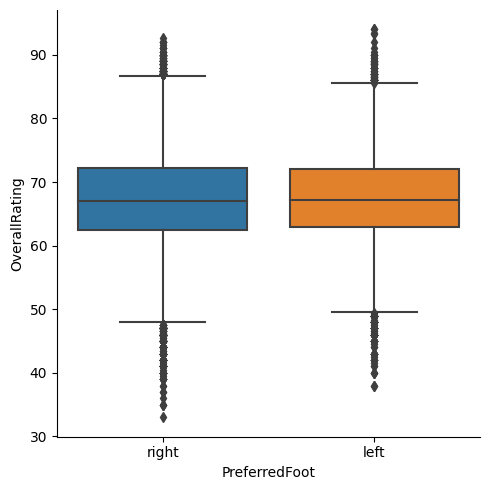

In [47]:
sns.catplot(x="PreferredFoot", y="OverallRating", data=players, kind="box")

<AxesSubplot: xlabel='PreferredFoot', ylabel='count'>

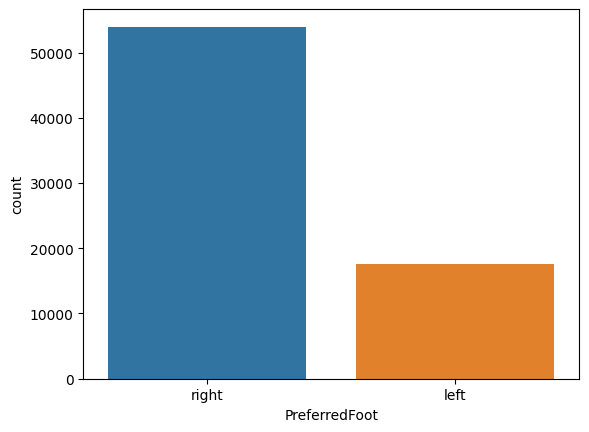

In [48]:
sns.countplot(x=players["PreferredFoot"])

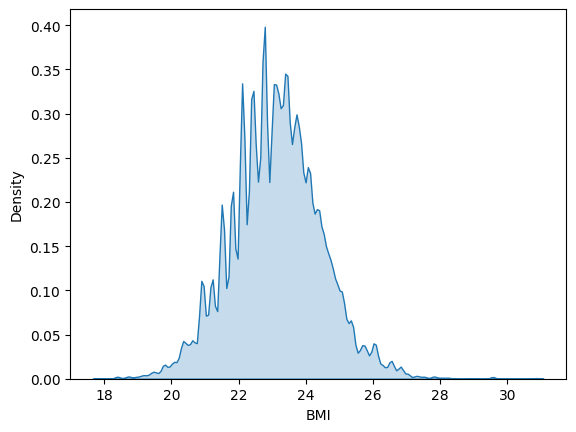

In [77]:
sns.kdeplot(data=players["BMI"], fill=True, legend=True, bw_adjust=0.5)

<AxesSubplot: ylabel='Density'>

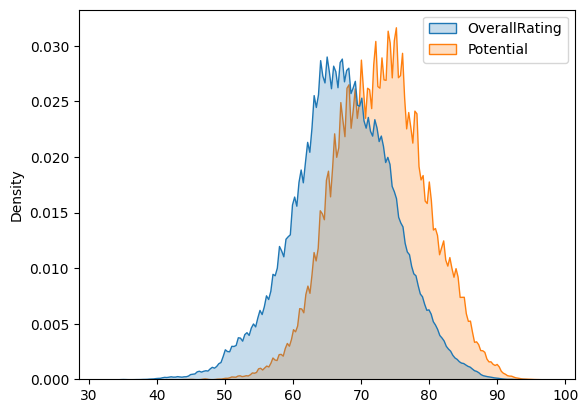

In [71]:
sns.kdeplot(
    data=players[["OverallRating", "Potential"]], fill=True, legend=True, bw_adjust=0.5
)

In [65]:
players["AttackWorkRate"].value_counts()
allowed_values = ["high", "medium", "low"]

players.loc[~players["AttackWorkRate"].isin(allowed_values), "AttackWorkRate"] = np.nan
players["AttackWorkRate"].value_counts()

medium    50394
high      14719
low        3570
Name: AttackWorkRate, dtype: int64

<AxesSubplot: xlabel='AttackWorkRate', ylabel='count'>

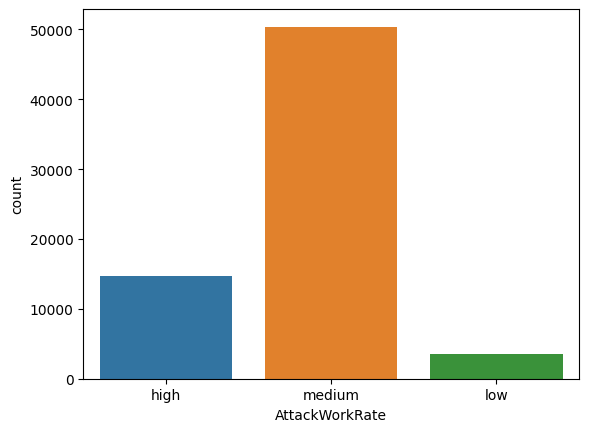

In [66]:
sns.countplot(data=players, x="AttackWorkRate")

In [68]:
players["DefenceWorkRate"].value_counts()
allowed_values = ["high", "medium", "low"]
players.loc[
    ~players["DefenceWorkRate"].isin(allowed_values), "DefenceWorkRate"
] = np.nan
players["DefenceWorkRate"].value_counts()

medium    51851
high       9721
low        7048
Name: DefenceWorkRate, dtype: int64

<AxesSubplot: xlabel='DefenceWorkRate', ylabel='count'>

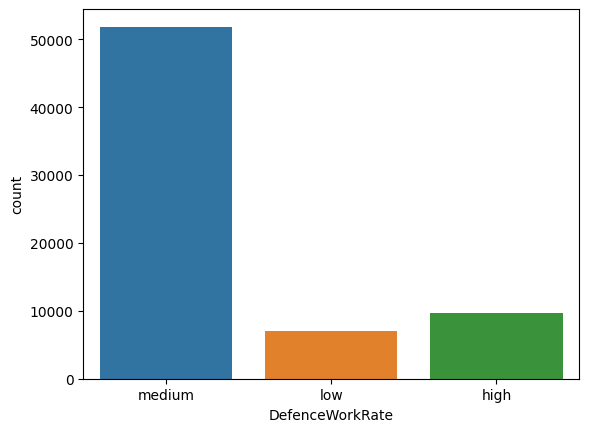

In [69]:
sns.countplot(data=players, x="DefenceWorkRate")

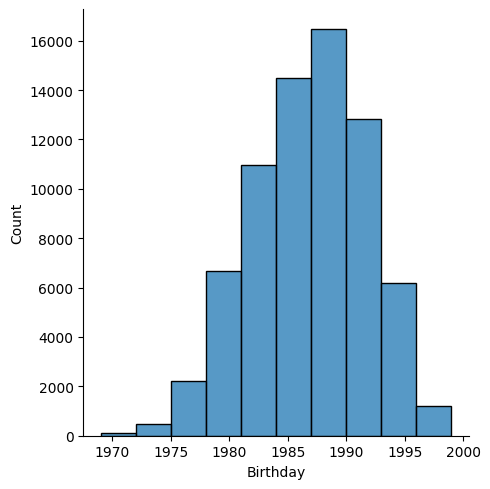

In [64]:
sns.displot(data=players, x="Birthday", bins=10)

<AxesSubplot: ylabel='Density'>

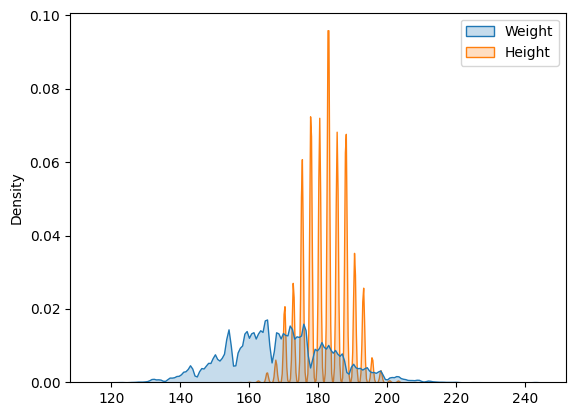

In [75]:
sns.kdeplot(data=players[["Weight", "Height"]], fill=True, legend=True, bw_adjust=0.5)

<AxesSubplot: xlabel='Height', ylabel='Weight'>

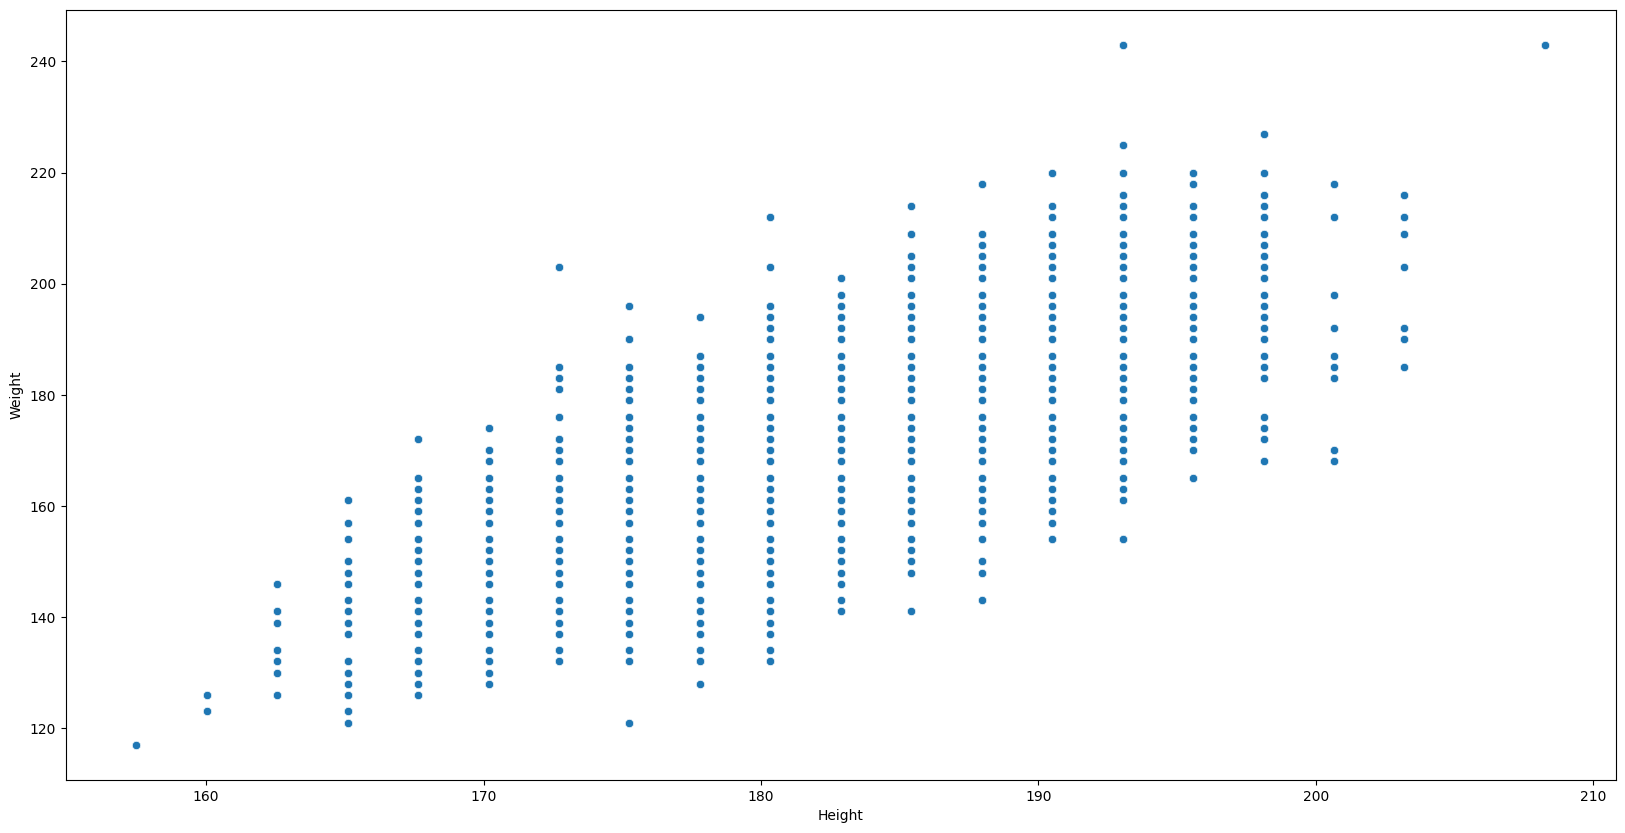

In [78]:
plt.figure(figsize=(20, 10))
sns.scatterplot(data=players, x="Height", y="Weight")

<AxesSubplot: xlabel='HomeGoal', ylabel='count'>

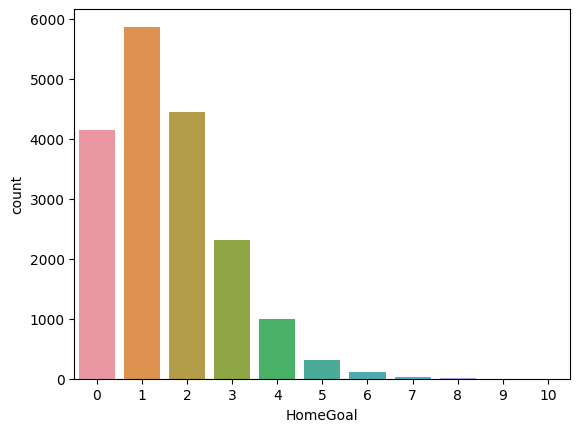

In [528]:
sns.countplot(x="HomeGoal", data=matches)

<AxesSubplot: xlabel='AwayGoal', ylabel='count'>

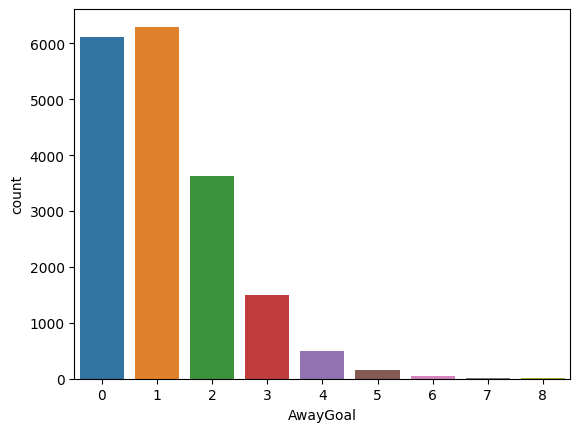

In [529]:
sns.countplot(x="AwayGoal", data=matches)

In [531]:
goals_season = matches[["Date","HomeGoal","AwayGoal"]].groupby(by="Date").sum()

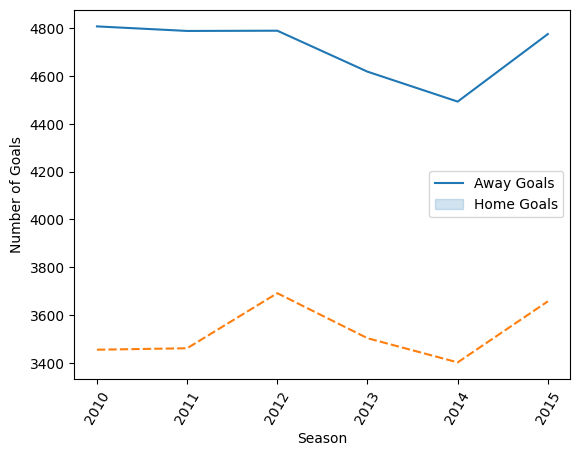

In [532]:
sns.lineplot(data=goals_season)
plt.xticks(rotation = 60)


new_labels = ["Away Goals","Home Goals"]
plt.ylabel("Number of Goals")
plt.xlabel("Season")
plt.legend(labels=new_labels)
plt.show()

plt.show()

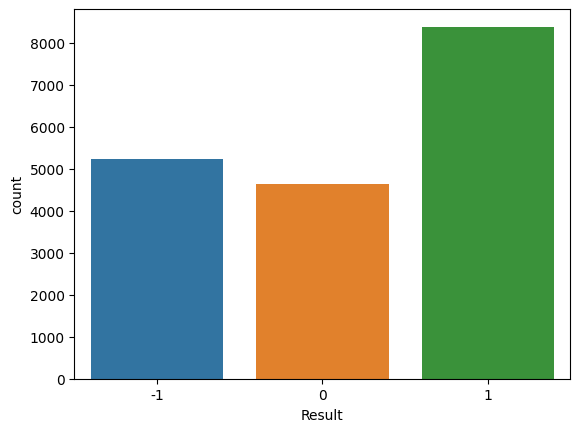

In [534]:
sns.countplot(x=matches['Result']);

# Machine Learning

In [7]:
X = matches.loc[:, "HomePlayer1":"AwayDefenceTeamWidth"]
y = matches["Result"]

# Logistic Regression

In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=101
)

In [9]:
scaler = StandardScaler()

In [10]:
scaled_X_train = scaler.fit_transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [11]:
log_model = LogisticRegression(solver="saga", multi_class="ovr", max_iter=5000)

In [12]:
log_model.fit(scaled_X_train, y_train)

LogisticRegression(max_iter=5000, multi_class='ovr', solver='saga')

In [13]:
y_predict = log_model.predict(scaled_X_test)

In [14]:
accuracy_score(y_test, y_predict)

0.5329971497478623

In [15]:
confusion_matrix(y_test, y_predict)

array([[ 665,   14,  610],
       [ 386,    9,  768],
       [ 338,   14, 1757]], dtype=int64)

In [16]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

          -1       0.48      0.52      0.50      1289
           0       0.24      0.01      0.01      1163
           1       0.56      0.83      0.67      2109

    accuracy                           0.53      4561
   macro avg       0.43      0.45      0.39      4561
weighted avg       0.46      0.53      0.45      4561



# PCA

In [31]:
y = matches["Result"]

In [32]:
sc = StandardScaler()
X_scaled = sc.fit_transform(X)

In [33]:
from sklearn.decomposition import PCA

pca = PCA(n_components=None)
pca.fit(X_scaled)

PCA()

In [34]:
# Get the eigenvalues
print("Eigenvalues:")
print(pca.explained_variance_)
print()

Eigenvalues:
[12.81815339  6.78252831  3.57205109  2.80239758  1.94679654  1.40591161
  1.29367579  1.16092196  1.13505052  0.957682    0.93449086  0.8412907
  0.83229984  0.77221057  0.71792242  0.7086089   0.63875081  0.62887734
  0.58384995  0.49243508  0.43914639  0.38618414  0.36620953  0.35025182
  0.3425      0.3391859   0.33812858  0.3313499   0.32883063  0.32506565
  0.32347215  0.32051129  0.31814752  0.31608476  0.30908973  0.30573518
  0.30271971  0.29989641  0.29732915  0.29452041  0.29152749  0.28776639
  0.27815121  0.27721767  0.26280362  0.2488984   0.22083535  0.2067002
  0.13526154  0.13331494]



In [35]:
# Get explained variances
print("Variances (Percentage):")
print(pca.explained_variance_ratio_ * 100)
print()

Variances (Percentage):
[25.63490151 13.56431303  7.14371058  5.60448792  3.89337966  2.81166909
  2.58720974  2.32171666  2.26997661  1.915259    1.86887928  1.68248916
  1.66450842  1.54433648  1.43576614  1.41714011  1.27743159  1.25768574
  1.16763588  0.98481618  0.87824464  0.77232593  0.73237891  0.70046525
  0.68496246  0.67833461  0.67622009  0.66266347  0.6576252   0.65009566
  0.64690883  0.64098745  0.63626016  0.63213486  0.61814558  0.61143684
  0.60540624  0.59975994  0.5946257   0.58900853  0.58302303  0.57550124
  0.55627192  0.55440495  0.52557844  0.49776952  0.44164649  0.41337774
  0.27050826  0.26661527]



Text(0, 0.5, 'Explained variance (%)')

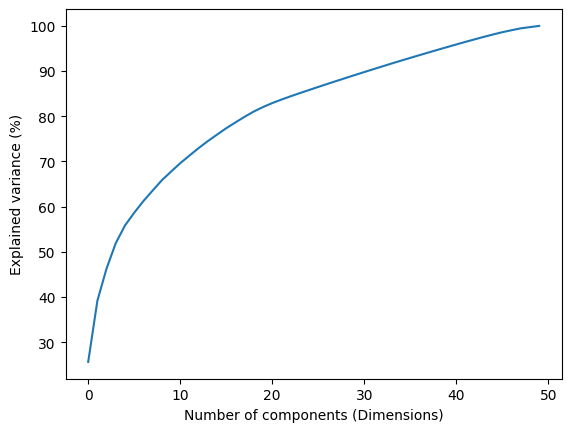

In [36]:
# Make the scree plot
plt.plot(np.cumsum(pca.explained_variance_ratio_ * 100))
plt.xlabel("Number of components (Dimensions)")
plt.ylabel("Explained variance (%)")

In [37]:
# Do feature scaling
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_scaled = sc.fit_transform(X)

# Apply PCA
from sklearn.decomposition import PCA

pca = PCA(n_components=6)
X_pca = pca.fit_transform(X_scaled)

# Get the transformed dataset
X_pca = pd.DataFrame(X_pca)
print(X_pca.head())
print("\nSize: ")
print(X_pca.shape)

          0         1         2         3         4         5
0  0.044868 -0.114176  0.935225  2.149780 -3.420784 -1.233728
1 -1.019202  0.097282  0.189511  2.211752 -3.471305 -1.305179
2 -3.461115  0.659037 -2.215763  2.379247 -3.978320 -0.545659
3 -2.613825  0.578908 -1.862752  2.364905 -2.226768 -1.196255
4 -2.469157  0.470433 -1.822468  0.786344 -1.931345 -0.391459

Size: 
(18243, 6)


<AxesSubplot: >

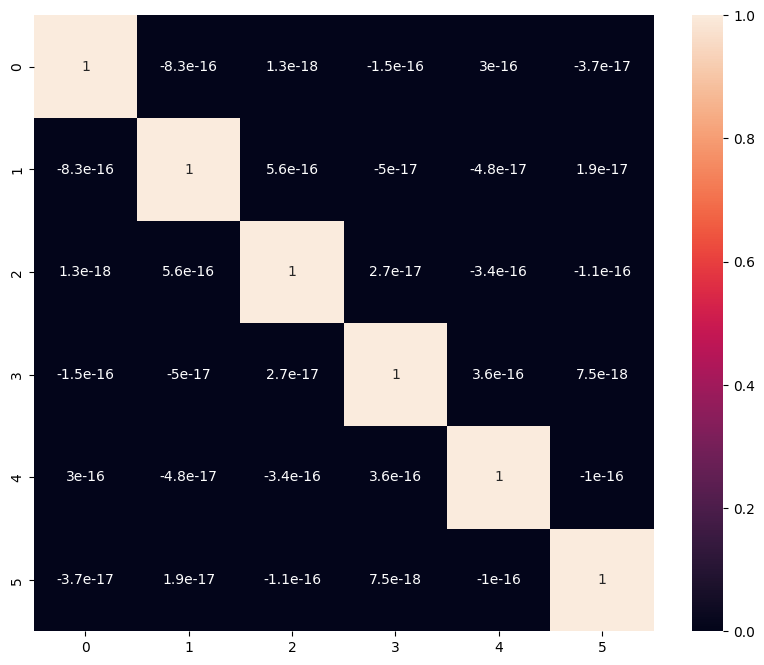

In [38]:
fig = plt.figure(figsize=(10, 8))

sns.heatmap(X_pca.corr(), annot=True)

Train accuracy: 0.52
Test accuracy: 0.52

Test confusion_matrix


Text(50.722222222222214, 0.5, 'True')

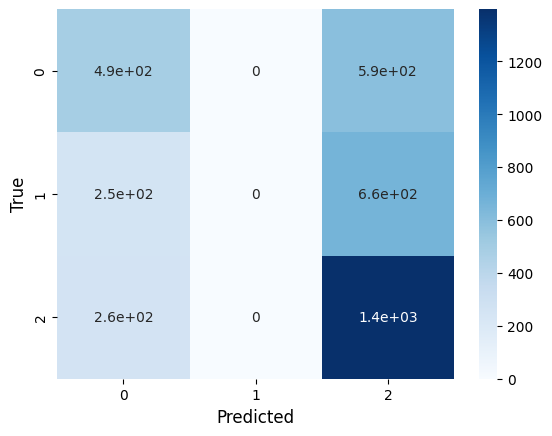

In [39]:
# Make train and test sets
from sklearn.model_selection import train_test_split

X_train_pca, X_test_pca, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.20, shuffle=True, random_state=2
)

# Initialize the logistic regression model
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=2500)

# Train the model
clf.fit(X_train_pca, y_train)

# Make predictions
y_pred = clf.predict(X_test_pca)  # Predictions
y_true = y_test  # True values

# Measure accuracy
from sklearn.metrics import accuracy_score
import numpy as np

print("Train accuracy:", np.round(accuracy_score(y_train, clf.predict(X_train_pca)), 2))
print("Test accuracy:", np.round(accuracy_score(y_true, y_pred), 2))

# Make the confusion matrix
from sklearn.metrics import confusion_matrix

cf_matrix = confusion_matrix(y_true, y_pred)
print("\nTest confusion_matrix")
sns.heatmap(cf_matrix, annot=True, cmap="Blues")
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("True", fontsize=12)

In [40]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

          -1       0.49      0.45      0.47      1078
           0       0.00      0.00      0.00       916
           1       0.53      0.84      0.65      1655

    accuracy                           0.52      3649
   macro avg       0.34      0.43      0.37      3649
weighted avg       0.38      0.52      0.43      3649



C:\Users\Space\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Space\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Space\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

# Random Forest

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=101
)

In [42]:
from sklearn.ensemble import RandomForestClassifier

# Use 10 random trees
model = RandomForestClassifier(n_estimators=10, max_features="sqrt", random_state=101)

In [43]:
model.fit(X_train, y_train)
preds = model.predict(X_test)

In [44]:
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    plot_confusion_matrix,
    accuracy_score,
)

confusion_matrix(y_test, preds)

array([[ 660,  284,  608],
       [ 451,  248,  691],
       [ 494,  464, 1573]], dtype=int64)

In [45]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

          -1       0.41      0.43      0.42      1552
           0       0.25      0.18      0.21      1390
           1       0.55      0.62      0.58      2531

    accuracy                           0.45      5473
   macro avg       0.40      0.41      0.40      5473
weighted avg       0.43      0.45      0.44      5473



# Random Forest Grid Search

In [555]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [556]:
n_estimators=[25,75, 100, ]
max_features= [14, 28, 42]
bootstrap = [True,False]
oob_score = [True,False]

In [557]:
param_grid = {'n_estimators':n_estimators,
             'max_features':max_features,
             'bootstrap':bootstrap,
             'oob_score':oob_score} 

In [558]:
rfc = RandomForestClassifier()
grid = GridSearchCV(rfc,param_grid)

In [ ]:
grid.fit(X_train,y_train)

C:\Users\Space\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Space\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
C:\Users\Space\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\ensemble\_forest.py:586: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(


In [ ]:
grid.best_params_

In [ ]:
predictions = grid.predict(X_test)

In [ ]:
print(classification_report(y_test,predictions))

In [ ]:
rfc = RandomForestClassifier(bootstrap = True, max_features = 28, n_estimators = 15, oob_score = False)

In [ ]:
rfc.fit(X_train,y_train)
preds = rfc.predict(X_test)

In [ ]:
confusion_matrix(y_test,preds)

In [ ]:
print(classification_report(y_test,preds))

# ELI5

In [537]:
log_model.fit(X_test, y_test)

perm = PermutationImportance(log_model, random_state=1)

eli.show_prediction(log_model, X_test.iloc[1],
                    feature_names=list(X.columns),
                    show_feature_values=True)